In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym
from gymnasium.wrappers import PixelObservationWrapper, TransformObservation, FrameStack, GrayScaleObservation, ResizeObservation
from stable_baselines3.common.buffers import ReplayBuffer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

        # Formula to calculate output of conv layer:
        $$H_{out} = \frac{(H_{in} + 2 * padding[0] - dilation[0] * (kernelSize[0] - 1) - 1}{stride[0]}+ 1$$
        $$W_{out} = \frac{(W_{in} + 2 * padding[1] - dilation[1] * (kernelSize[1] - 1) - 1}{stride[1]}+ 1$$

In [3]:
class DQNAtari(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(DQNAtari, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, 32, stride=4, kernel_size=8)
        self.conv2 = nn.Conv2d(32, 64, stride=2, kernel_size=4)
        self.conv3 = nn.Conv2d(64, 64, stride=1, kernel_size=3)
        # 64 * 7 * 7 is the output of last conv layer because of the formula above, for an input of 84*84
        self.linear = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions) # Head layer

    def forward(self, x):
        x = x.float() / 255 # Rescale input from [0, 255] to [0, 1]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.linear(x.view(x.size(0), -1)))
        return self.output(x)

In [8]:
class DQNCartPole(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(DQNCartPole, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, 64, stride=3, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, stride=2, kernel_size=4)
        self.conv3 = nn.Conv2d(64, 64, stride=1, kernel_size=3)
        self.flatten = nn.Flatten()
        #self.linear1 = nn.Linear(64 * 23 * 36, 512)
        self.linear1 = nn.Linear(6400, 512) # 84x84 input shape
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 64)
        self.head = nn.Linear(64, num_actions) # Head layer

    def forward(self, x):
        x = x / 255.0 # Rescale input from [0, 255] to [0, 1]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.head(x)

model = DQNCartPole(4, 2).to(device)
print(model)
#img = torch.rand([1, 4, 160, 240], device=device)
img = torch.rand([1, 4, 84, 84], device=device)
pred = model(img)
pred

DQNCartPole(
  (conv1): Conv2d(4, 64, kernel_size=(5, 5), stride=(3, 3))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=6400, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (head): Linear(in_features=64, out_features=2, bias=True)
)


tensor([[-0.0684, -0.0568]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [4]:
conv1 = nn.Conv2d(4, 32, stride=4, kernel_size=8)
conv2 = nn.Conv2d(32, 64, stride=2, kernel_size=4)
conv3 = nn.Conv2d(64, 64, stride=1, kernel_size=3)
img = torch.rand([4, 84, 84])

In [5]:
conv21 = nn.Conv2d(4, 64, stride=3, kernel_size=5)
conv22 = nn.Conv2d(64, 64, stride=2, kernel_size=4)
conv23 = nn.Conv2d(64, 64, stride=1, kernel_size=3)
img2 = torch.rand([4, 160, 240])
output2 = conv23(conv22(conv21(img2)))
print(output2.shape)

output2.view(output2.size(0), -1).shape

torch.Size([64, 23, 36])


torch.Size([64, 828])

In [10]:
def make_env(env_name="CartPole-v1", seed=0, obs_resize_shape=(160, 240)):
    env = gym.make(env_name, render_mode="rgb_array")
    env = PixelObservationWrapper(env)

    # PixelObservationWrapper replace Box space to Dict space env, we don't want because it won't work with following wrappers, so we directly returns the Pixels value
    env = TransformObservation(env, lambda obs: obs["pixels"])
    # Need to change the observation space to keep it true with observation after the TransformObservation wrapper
    env.observation_space = env.observation_space['pixels']

    env = GrayScaleObservation(env)
    env = ResizeObservation(env, obs_resize_shape)
    env = FrameStack(env, 4)
    env.observation_space.seed(seed)
    env.action_space.seed(seed)

    return env

In [11]:
plt.figure(figsize=(18, 9))
def plot_model(self, score, episode):
    self.scores.append(score)
    self.episodes.append(episode)
    self.averages.append(sum(self.scores[-50:]) / len(self.scores[-50:]))

    plt.plot(self.episodes, self.averages, 'r')
    plt.plot(self.episodes, self.scores, 'b')
    plt.ylabel('Score', fontsize=18)
    plt.xlabel('Steps', fontsize=18)

    dqn = "DQN_"
    soft_update = ""
    dueling = ""
    greedy = ""
    PER = ""

    if self.ddqn: dqn = 'DDQN_'
    if self.soft_update: soft_update = '_soft'
    if self.dueling: dueling = '_Dueling'
    if self.epsilon_greedy: greedy = '_Greedy'
    if self.use_PER: PER = "_PER"

    try:
        plt.savefig(dqn + "CartPole-v1_CNN" + soft_update + dueling + greedy + PER + ".png")
    except OSError:
        pass

    return str(self.averages[-1])[:5]

<Figure size 1800x900 with 0 Axes>

In [12]:
class DQNAgent:
    def __init__(self):
        self.env = make_env(obs_resize_shape=(84, 84))

        self.env.spec.max_episode_steps = 4000
        self.MAX_EPISODES = 2000
        # self.MAX_EPISODES = 1

        self.GAMMA = 0.95
        self.TAU = 0.1
        self.BATCH_SIZE = 32

        self.epsilon = 1.0
        self.EPSILON_START = 1.0
        self.EPSILON_END = 0.01
        self.EPSILON_DECAY = 0.0005

        self.TRAIN_FREQUENCY = 4

        self.LEARNING_RATE = 0.00025

        self.memory = ReplayBuffer(
            buffer_size=10_000,
            observation_space=self.env.observation_space,
            action_space=self.env.action_space,
            device=device,
            optimize_memory_usage=True,
            handle_timeout_termination=False
        )

        self.scores = []
        self.episodes = []
        self.means = []

        self.q_network = DQNCartPole(4, self.env.action_space.n).to(device)
        self.target_network = DQNCartPole(4, self.env.action_space.n).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.LEARNING_RATE)

    def act(self, state, current_step):
        """
        Choose an action either random or predicted by q_network

        :param state: current observation state
        :param current_step: global step
        :return: an action as uint Tensor (use .item() to retrieve the value)
        """
        # Epsilon-Greedy strategy
        self.epsilon = self.EPSILON_END + (self.EPSILON_START - self.EPSILON_END) * np.exp(-self.EPSILON_DECAY * current_step)

        if self.epsilon > np.random.rand():
            # Random action
            return np.array(self.env.action_space.sample())
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(np.array(state), device=device).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return q_values.argmax(dim=1)[0].cpu().numpy()

    def remember(self, state, action, next_state, reward, done, infos):
        self.memory.add(state, next_state, action, reward, done, infos)

    def update_target_model(self):
        # Soft update of the target netwok's weights
        target_net_state_dict = self.target_network.state_dict()
        policy_net_state_dict = self.q_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.TAU + target_net_state_dict[key] * (1 - self.TAU)
        self.target_network.load_state_dict(target_net_state_dict)

    def optimize_model(self):
        minibatch = self.memory.sample(self.BATCH_SIZE)

        # Calculate Q values for current states
        # For each q_values, get the action according to the minibatch
        q_values = self.q_network(minibatch.observations).gather(1, minibatch.actions)

        # Then, calculate the best actions for the next states, and return its indices
        with torch.no_grad():
            best_next_actions = self.q_network(minibatch.next_observations).argmax(1).unsqueeze(1)

        # Calculate the Q values for the next states using the target network, and return the action according to the best next action returned by the q network
        target_next_q_values = self.target_network(minibatch.next_observations).gather(1, best_next_actions)

        # Calculate the target Q values using Double DQN
        target_q_values = minibatch.rewards + (1 - minibatch.dones) * self.GAMMA * target_next_q_values

        # Compute the loss
        loss = F.mse_loss(q_values, target_q_values)

        # Optimise Q network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_data(self, score, episode, show_result=False):
        self.scores.append(score)
        self.episodes.append(episode)
        self.means.append(sum(self.scores[-100:]) / len(self.scores[-100:]))

        plt.figure(1)
        if show_result:
            plt.title("Result")
        else:
            plt.clf()
            plt.title("Training...")

        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.plot(self.episodes, self.means, 'r')
        plt.plot(self.episodes, self.scores, 'b')

        plt.pause(0.001) # Pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                print(f"Episode: {episode}/{self.MAX_EPISODES}, score: {self.scores[-1:]}, epsilon: {self.epsilon:.2}, Mean score: {self.means[-1:][0]}")
                print("--------------------------")
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def run(self):
        global_step = 0
        episode_reward_history = []
        for episode in range(self.MAX_EPISODES):
            state, _ = self.env.reset()
            done = False
            steps_alive = 0
            while not done:
                global_step += 1
                action = self.act(state, global_step)
                next_state, reward, terminated, truncated, infos = self.env.step(action.item())
                done = terminated or truncated

                if not done or steps_alive == self.env.spec.max_episode_steps - 1:
                    reward = reward
                else:
                    reward = -100

                self.remember(state, action, next_state, reward, done, infos)

                state = next_state
                steps_alive += 1

                if done:
                    if episode % 4 == 0:
                        self.update_target_model()

                    self.plot_data(steps_alive, episode)

                self.optimize_model()


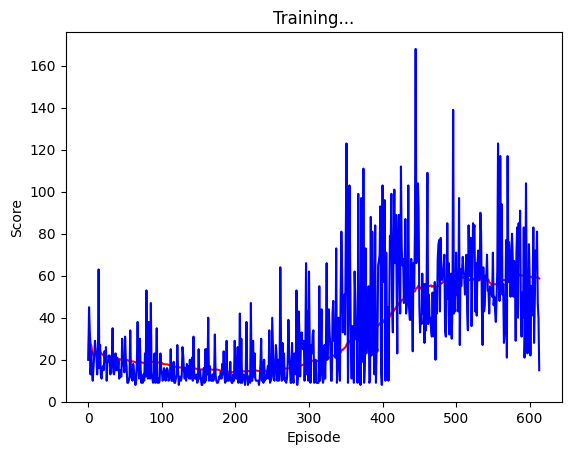

Episode: 613/2000, score: [15], epsilon: 0.01, Mean score: 58.66
--------------------------


<Figure size 640x480 with 0 Axes>

In [ ]:
agent = DQNAgent()
agent.run()